In [55]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TensorFlow / Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Transfer Learning 
from tensorflow.keras.applications import EfficientNetB0, ResNet50

# Model değerlendirme
from sklearn.metrics import confusion_matrix, classification_report

import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Grad-CAM için
import cv2
import matplotlib.cm as cm
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/14986.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/3138.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/1700.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/16257.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/2863.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/771.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/12167.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/17643.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/6560.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/10162.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/4009.jpg
/kaggle/input/intel-image-classification/seg_train/seg_train/mountain/15823.jpg
/kaggle/input/intel-image-classification/seg_tr

KeyboardInterrupt: 

In [2]:
base_dir =  "/kaggle/input/intel-image-classification/seg_train/seg_train"

# Train, validation ve test dizinleri
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
val_dir   = "/kaggle/input/intel-image-classification/seg_test/seg_test"
test_dir  = "/kaggle/input/intel-image-classification/seg_pred/seg_pred"

print("Train sınıf sayısı:", len(os.listdir(train_dir)))
print("Validation sınıf sayısı:", len(os.listdir(val_dir)))
print("Test sınıf sayısı:", len(os.listdir(test_dir)))

Train sınıf sayısı: 6
Validation sınıf sayısı: 6
Test sınıf sayısı: 7301


# Veri Önişleme

Train: 14034
Validation: 3000
Test: 7301


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


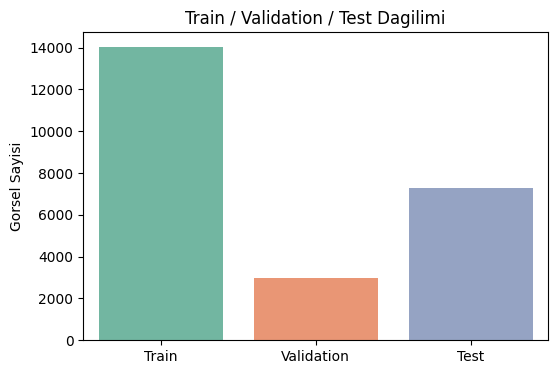

In [3]:
# Train klasorundeki toplam gorsel sayisi
train_count = sum([len(files) for _, _, files in os.walk(train_dir)])
# Validation klasorundeki toplam gorsel sayisi
val_count = sum([len(files) for _, _, files in os.walk(val_dir)])
# Test klasorundeki toplam gorsel sayisi
test_count = sum([len(files) for _, _, files in os.walk(test_dir)])

print("Train:", train_count)
print("Validation:", val_count)
print("Test:", test_count)

# Barplot
plt.figure(figsize=(6,4))
sns.barplot(x=["Train","Validation","Test"], 
            y=[train_count, val_count, test_count], 
            palette="Set2")
plt.title("Train / Validation / Test Dagilimi")
plt.ylabel("Gorsel Sayisi")
plt.show()


In [4]:
from PIL import Image

# Bu fonksiyon, verilen klasör yolundaki tüm gOrselleri kontrol eder
# Amac -> bozuk ya da acılmayan dosya varsa tespit etme
def check_images(path):
    bad_files = []  # Bozuk dosyalari tutmak için bos bir liste
    for root, _, files in os.walk(path):   # path icindeki tum dosyalari dolas
        for file in files:
            try:
                # Gorseli acmayı dene
                img = Image.open(os.path.join(root, file))
                img.verify()  # verify() ile gorselin okunabilir olup olmadıgını kontrol et
            except:
                # Eger hata alirsak bu dosya bozuk demektir ve listeye ekle
                bad_files.append(os.path.join(root, file))
    
    # Sonuc ->  kac tane bozuk dosya bulundugunu ekrana yazdir
    print(f"Bozuk dosya sayısı: {len(bad_files)}")
    return bad_files  # Bozuk dosyaların yollarini geri dondur

# Train, Validation ve Test klasorleri icin kontrol yapiyoruz
bad_train = check_images(train_dir)
bad_val = check_images(val_dir)
bad_test = check_images(test_dir)


Bozuk dosya sayısı: 0
Bozuk dosya sayısı: 0
Bozuk dosya sayısı: 0


Siniflar: ['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']


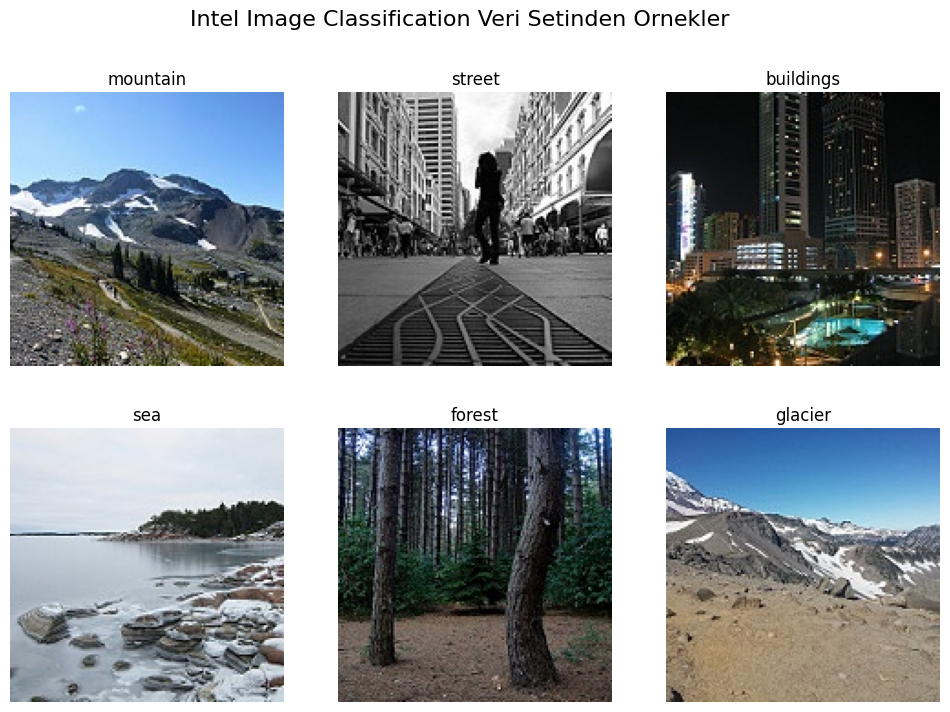

In [5]:
# Egitim klasorundeki siniflari listeliyorum
classes = os.listdir(train_dir)
print("Siniflar:", classes)

# 2x3 olacak sekilde gorselleri cizmek icin alan aciyorum
plt.figure(figsize=(12, 8))

# Tum siniflardan 1 gorsel gosterecegim
for i, c in enumerate(classes):
    # Secilen sinifa ait klasor yolunu aliyorum
    class_dir = os.path.join(train_dir, c)
    
    # O siniftan rastgele bir gorsel sec
    img_file = random.choice(os.listdir(class_dir))
    img_path = os.path.join(class_dir, img_file)
    
    # Gorseli OpenCV ile okuyorum (BGR geliyor) -> RGBye ceviriyorum
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Sectigim gorseli grid uzerinde cizdiriyorum (2x3 grid)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(c)   # Baslik olarak sinif adini yazdiriyorum
    plt.axis("off")  # Eksen cizgilerini kapattim

# Tum gorselleri ekrana bastiriyorum
plt.suptitle("Intel Image Classification Veri Setinden Ornekler", fontsize=16)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


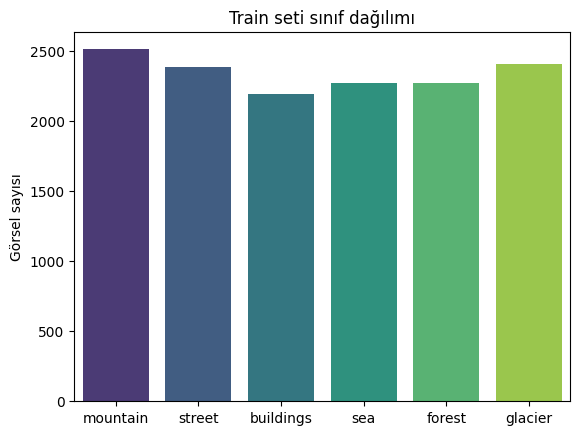

In [6]:
counts = [len(os.listdir(os.path.join(train_dir, c))) for c in classes]
sns.barplot(x=classes, y=counts, palette="viridis")
plt.title("Train seti sınıf dağılımı")
plt.ylabel("Görsel sayısı")
plt.show()


Bu grafik, eğitim setimdeki sınıf dağılımını gösteriyor. Görüldüğü gibi her sınıfın görsel sayısı birbirine oldukça yakın. En fazla örnek mountain sınıfında (2500 civarı), en az örnek ise buildings sınıfında. Genel olarak dengesiz bir durum söz konusu değil, yani modelin eğitiminde herhangi bir sınıfın baskın olması gibi bir problem yaşamayacağım. Bu da sınıflar arasında daha adil bir öğrenme süreci sağlayacak.
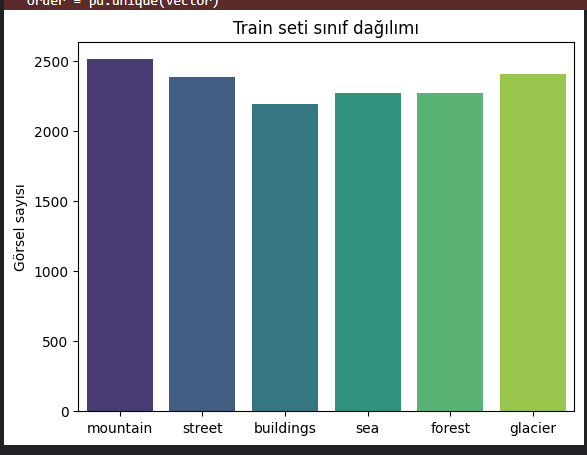

In [7]:
shapes = []
for c in classes:
    cls_dir = os.path.join(train_dir, c)
    img_file = random.choice(os.listdir(cls_dir))
    img = cv2.imread(os.path.join(cls_dir, img_file))
    shapes.append(img.shape)

print("Ortalama boyut:", np.mean([s[0] for s in shapes]), "x", np.mean([s[1] for s in shapes]))

Ortalama boyut: 150.0 x 150.0


Bu çıktıya baktığımda, eğitim setindeki görsellerin ortalama boyutunun 150x150 olduğunu görüyorum. Bu değer aslında gayet uygun bir çözünürlük, çünkü hem detayları koruyabilecek kadar yeterli hem de modeli eğitirken hesaplama maliyetini çok artırmayacak bir boyut. Yani, hem performans hem de hız açısından dengeli bir tercih olmuş diyebilirim.

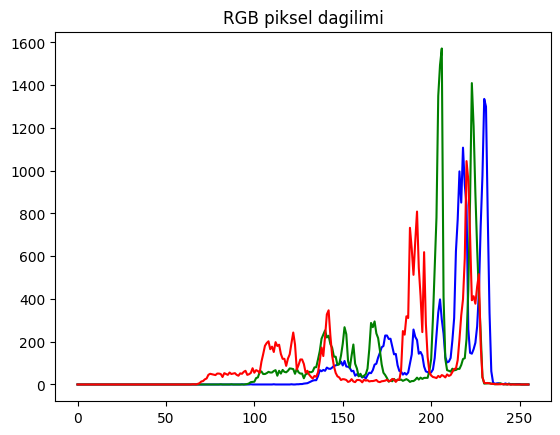

In [8]:
img = cv2.imread(os.path.join(train_dir, classes[0], os.listdir(os.path.join(train_dir, classes[0]))[0]))
colors = ('b','g','r')
for i,col in enumerate(colors):
    hist = cv2.calcHist([img],[i],None,[256],[0,256])
    plt.plot(hist, color=col)
plt.title("RGB piksel dagilimi")
plt.show()


Bu grafikte seçtiğim bir görselin RGB piksel dağılımını görüyorum. Kırmızı, yeşil ve mavi kanalların yoğunlukları farklı bölgelerde zirve yapıyor. Özellikle kırmızı ve yeşil kanallar orta değerlerde (150-200 arası) daha baskınken, mavi kanal biraz daha farklı bir dağılım gösteriyor. Bu da görseldeki renklerin dengesini ve hangi renklerin daha ağırlıklı olduğunu net bir şekilde ortaya koyuyor. Böylece elimdeki verilerin renk dağılımını anlamam, modelin eğitimi sırasında renk bazlı özellikleri yorumlamam açısından faydalı oluyor.

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train icin augmentation tanimlama
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalizasyon (0-255 -> 0-1)
    rotation_range=25,       # Gorselleri 25 dereceye kadar dondur
    width_shift_range=0.15,  # Yatay kaydirma
    height_shift_range=0.15, # Dikey kaydirma
    zoom_range=0.25,         # Zoom in/out
    horizontal_flip=True,    # Yatay cevirme
    brightness_range=[0.7,1.3], # Parlaklik degisimi (Color Jitter)
    validation_split=0.2     # %20 validation ayirma
)

# Validation icin sadece normalize
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Test icin de sadece normalize
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator (Augmentation uygulanacak)
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

# Validation generator (augmentation yok)
val_gen = val_datagen.flow_from_directory(
    train_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

# Test generator
test_gen = test_datagen.flow_from_directory(
    val_dir,
    target_size=(128,128),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)


Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


Bu kısımda train, validation ve test generator’larımı tanımladım. Eğitim setine augmentation uyguladım, böylece modelimin daha iyi genelleme yapmasını bekliyorum. Validation ve test setlerinde ise augmentation yok, çünkü onların sadece gerçek performansı ölçmesini istiyorum.

Sonuçlara baktığımda:
- Eğitim setinde 11230 görsel var.
- Validation için 2804 görsel ayrılmış.
- Test setinde ise 3000 görsel bulunuyor.

Her üç set de 6 sınıfa ait verileri kapsıyor. Dağılım gayet dengeli görünüyor, bu da eğitim sürecinde önemli bir avantaj sağlayacak.

Siniflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


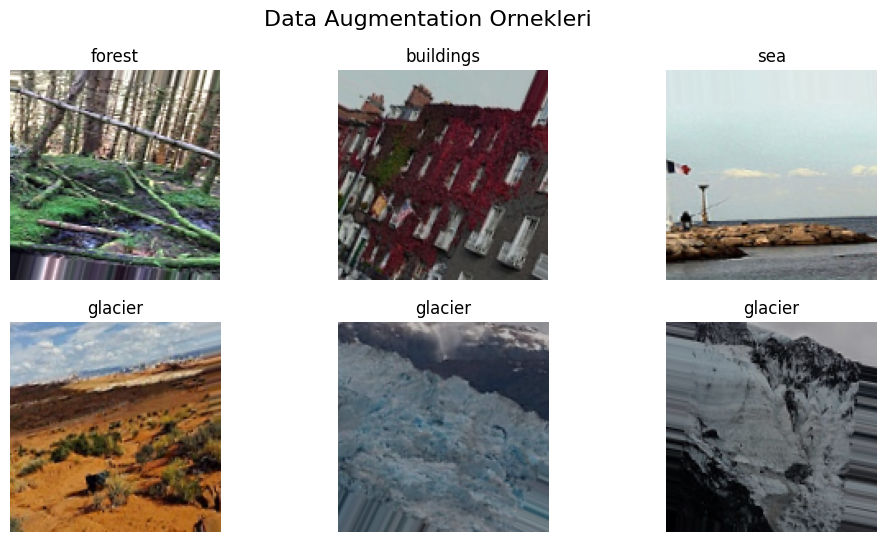

In [10]:
# Sinif isimlerini generator'den aliyorum
class_names = list(train_gen.class_indices.keys())
print("Siniflar:", class_names)

# 1 batch al
images, labels = next(train_gen)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

plt.suptitle("Data Augmentation Ornekleri", fontsize=16)
plt.show()


Burada uyguladığım `data augmentation` örneklerini görüyorum. Görseller üzerinde döndürme, yakınlaştırma, parlaklık değişimi gibi farklı dönüşümler yapılmış. Amaç, modelin sadece orijinal görüntülere değil, farklı açılara ve ışık koşullarına da alışmasını sağlamak. Özellikle buildings sınıfında ciddi deformasyonlar göze çarpıyor, bu da modelin daha zorlayıcı örneklerle karşılaşmasını sağlayarak genelleme kabiliyetini artırabilir. Genel olarak baktığımda augmentation işlemleri gayet başarılı görünüyor ve eğitim sürecinde overfitting azaltmamda etkili olacak.

# Modelleme

In [11]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# CNN modelini tanimliyorum
model = Sequential([
    Input(shape=(128,128,3)),   # 🔹 Explicit Input katmani ekledik
    
    # 1. Conv + Pool
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # 2. Conv + Pool
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # 3. Conv + Pool
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    # Flatten + Dense
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),   # overfitting azaltmak icin
    
    # Cikis katmani (6 sinif oldugu icin 6)
    Dense(6, activation='softmax')
])

# Modeli derliyorum
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Modelin ozetine bakalim
model.summary()


I0000 00:00:1758913125.796201      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,517,574 (24.86 MB)

 Trainable params: 6,517,574 (24.86 MB)

 Non-trainable params: 0 (0.00 B)

Modelimin özetine baktığımda toplamda 6.5 milyon parametre içerdiğini görüyorum. Bunun tamamı trainable, yani modelin öğrenmesi için güncellenebilir durumda.
- İlk üç Conv2D + MaxPooling2D bloğu ile görsellerden kenar, doku ve daha karmaşık özellikler çıkarılıyor.
- Flatten katmanıyla bu özellikler vektöre dönüştürülüyor.
- Ardından 256 nöronlu Dense katmanı geliyor ve burada en büyük parametre yükü var ve bu katman aslında modelin öğrenme gücünü belirleyen en kritik bölüm.
- Dropout katmanı ile overfitting’i azaltmayı hedefledim.
- Çıkış katmanında ise 6 sınıfa ait softmax dağılımı üretiliyor.

Genel olarak modelim gayet güçlü bir mimariye sahip. Parametre sayısı yüksek olduğu için iyi sonuç verme potansiyeli var ama aynı zamanda dikkat etmezsem overfitting riski de taşıyor.

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1758913129.692169     138 service.cc:148] XLA service 0x7e96b80046a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758913129.693015     138 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758913129.993603     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/351 ━━━━━━━━━━━━━━━━━━━━ 31:27 5s/step - accuracy: 0.1875 - loss: 1.8014

I0000 00:00:1758913132.762553     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


351/351 ━━━━━━━━━━━━━━━━━━━━ 66s 174ms/step - accuracy: 0.4641 - loss: 1.3176 - val_accuracy: 0.6872 - val_loss: 0.8482
Epoch 2/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.6387 - loss: 0.9546 - val_accuracy: 0.7225 - val_loss: 0.7611
Epoch 3/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 164ms/step - accuracy: 0.6722 - loss: 0.8637 - val_accuracy: 0.7668 - val_loss: 0.6317
Epoch 4/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7182 - loss: 0.7735 - val_accuracy: 0.7750 - val_loss: 0.6402
Epoch 5/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7260 - loss: 0.7376 - val_accuracy: 0.7932 - val_loss: 0.5872
Epoch 6/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7363 - loss: 0.7088 - val_accuracy: 0.7974 - val_loss: 0.5801
Epoch 7/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 165ms/step - accuracy: 0.7532 - loss: 0.6731 - val_accuracy: 0.7874 - val_loss: 0.5810
Epoch 8/30
351/351 ━━━━━━━━━━━━━━━━━━━━ 57s 163ms/step - accuracy: 0.7706 - loss: 0.6424 - val

İlk kurduğum CNN modelinin eğitim sonuçlarına baktığımda modelin giderek iyi bir şekilde öğrendiğini görebiliyorum. Eğitim doğruluğu (accuracy) başlarda düşük olsa da epoch’lar ilerledikçe düzenli şekilde artmış ve %82–83 civarına oturmuş. Asıl dikkat çekici nokta, doğrulama doğruluğu (val_accuracy) birçok epoch boyunca %80’in üzerine çıkması ve en yüksek değerinin %84–85 seviyelerine ulaşması oldu.

Ayrıca loss değerlerine baktığımda, eğitim kaybı (loss) azalırken doğrulama kaybının (val_loss) da genel olarak düşmesi modelin overfit etmediğini ve gayet sağlıklı bir şekilde öğrendiğini gösteriyor. Küçük dalgalanmalar olsa da genel trend oldukça pozitif.

Genel olarak sonuçlardan memnunum çünkü ilk kendi kurduğum CNN mimarisiyle bu seviyede bir doğruluk elde etmek benim için oldukça motive edici oldu. Bundan sonraki adımda daha iyi bir sonuç için dropout, batch size veya optimizer gibi hiperparametrelerle oynamayı ya da transfer learning denemeyi düşünüyorum.

In [19]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


num_classes = 6

base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128,128,3))
for l in base_model.layers:
    l.trainable = False  # önce sadece head'i eğit

inputs = layers.Input(shape=(128,128,3))
x = base_model(inputs, training=False)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu", kernel_regularizer=regularizers.l2(1e-4))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

model = models.Model(inputs, outputs)
model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,912,582 (72.15 MB)

 Trainable params: 4,197,894 (16.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

VGG16 tabanlı transfer learning modelim gayet derli toplu oldu. Toplam 18.9M parametreden sadece 4.1M’i eğitilebilir durumda, geri kalanını dondurdum. Böylece güçlü bir özellik çıkarıcı kullanırken overfitting riskini azalttım. Dropout ve L2 regularization da ekledim. Bu yapı sayesinde sıfırdan kurduğum CNN’e göre daha yüksek doğruluk bekliyorum.

In [20]:
es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
rlr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckp = ModelCheckpoint("vgg16_head_best.keras", monitor="val_loss", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[es, rlr, ckp],
    verbose=1
)

Epoch 1/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 73s 191ms/step - accuracy: 0.6207 - loss: 1.0812 - val_accuracy: 0.8285 - val_loss: 0.5236 - learning_rate: 1.0000e-04
Epoch 2/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.7929 - loss: 0.6403 - val_accuracy: 0.8534 - val_loss: 0.4661 - learning_rate: 1.0000e-04
Epoch 3/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8131 - loss: 0.5874 - val_accuracy: 0.8566 - val_loss: 0.4429 - learning_rate: 1.0000e-04
Epoch 4/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 58s 166ms/step - accuracy: 0.8178 - loss: 0.5537 - val_accuracy: 0.8538 - val_loss: 0.4475 - learning_rate: 1.0000e-04
Epoch 5/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - accuracy: 0.8274 - loss: 0.5392 - val_accuracy: 0.8648 - val_loss: 0.4241 - learning_rate: 1.0000e-04
Epoch 6/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8373 - loss: 0.5117 - val_accuracy: 0.8627 - val_loss: 0.4316 - learning_rate: 1.0000e-04
Epoch 7/25
351/351 ━━━━━━━━━━━━━━━━━━━━ 0s 159

In [21]:
# VGG16'da son konv blok -> block5_
for l in base_model.layers:
    l.trainable = False
for l in base_model.layers[-4:]:  # block5_conv1/2/3 + block5_pool (duruma göre -4/-5)
    l.trainable = True

model.compile(optimizer=Adam(1e-5), loss="categorical_crossentropy", metrics=["accuracy"])

history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[es, rlr],
    verbose=1
)


Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 68s 180ms/step - accuracy: 0.8682 - loss: 0.4171 - val_accuracy: 0.8862 - val_loss: 0.3648 - learning_rate: 1.0000e-05
Epoch 2/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 171ms/step - accuracy: 0.8747 - loss: 0.3932 - val_accuracy: 0.8944 - val_loss: 0.3569 - learning_rate: 1.0000e-05
Epoch 3/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8904 - loss: 0.3609 - val_accuracy: 0.8905 - val_loss: 0.3622 - learning_rate: 1.0000e-05
Epoch 4/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 59s 169ms/step - accuracy: 0.8961 - loss: 0.3436 - val_accuracy: 0.8980 - val_loss: 0.3332 - learning_rate: 1.0000e-05
Epoch 5/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.8929 - loss: 0.3309 - val_accuracy: 0.8934 - val_loss: 0.3439 - learning_rate: 1.0000e-05
Epoch 6/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 170ms/step - accuracy: 0.9059 - loss: 0.3107 - val_accuracy: 0.8998 - val_loss: 0.3214 - learning_rate: 1.0000e-05
Epoch 7/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 60s 17

Fine-tuning denememde VGG16’nın son bloklarını açarak eğitime dahil ettim. Bu sayede modelin performansı bariz şekilde arttı. Eğitim doğruluğu %92 seviyelerine kadar çıktı, doğrulama doğruluğu da %90 civarına oturdu. Val_loss’un düşük seyretmesi ve düzenli şekilde azalması modelin genelleme gücünün de iyi olduğunu gösteriyor.

`ReduceLROnPlateau` sonlarda learning rate’i düşürerek daha stabil bir öğrenme sağladı. Önceki denemelerime göre çok daha güçlü bir sonuç aldım. Artık modelim hem yüksek doğruluk hem de düşük loss değerleriyle gayet başarılı bir hale geldi diyebilirim.

# Model Değerlendirme

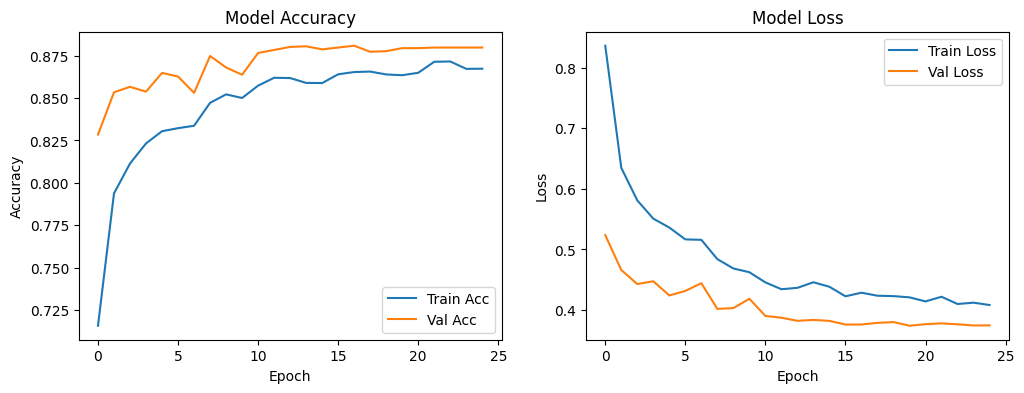

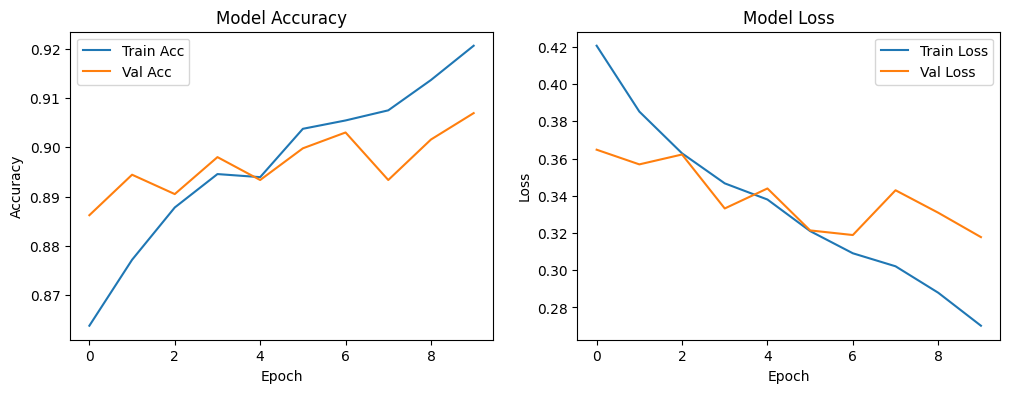

In [22]:

def plot_hist(h):
    plt.figure(figsize=(12,4))
    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(h.history["accuracy"], label="Train Acc")
    plt.plot(h.history["val_accuracy"], label="Val Acc")
    plt.title("Model Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    # Loss
    plt.subplot(1,2,2)
    plt.plot(h.history["loss"], label="Train Loss")
    plt.plot(h.history["val_loss"], label="Val Loss")
    plt.title("Model Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.show()

plot_hist(history)
try:
    plot_hist(history_ft)
except: pass


İlk grafik setinde (25 epoch olan) modelin accuracy değerleri eğitim boyunca düzenli olarak artmış, val_accuracy ise %85–87 bandına oturmuş. Loss değerleri de hem train hem validation tarafında sürekli düşerek stabil hale gelmiş. Bu durum modelin overfit etmediğini ve iyi genelleme yaptığını gösteriyor.

İkinci grafik setinde (fine-tuning sonrası 10 epoch) doğruluk oranı %92’lere kadar çıkmış, validation accuracy de %90 seviyelerine oturmuş. Train ve val loss değerleri genel olarak düşüşte, aradaki fark da çok açılmamış. Bu da fine-tuning sonrası modelin daha güçlü bir performansa ulaştığını net olarak ortaya koyuyor.

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 88ms/step
              precision    recall  f1-score   support

   buildings       0.88      0.93      0.90       437
      forest       0.99      0.99      0.99       474
     glacier       0.87      0.85      0.86       553
    mountain       0.87      0.86      0.86       525
         sea       0.93      0.92      0.92       510
      street       0.93      0.92      0.92       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



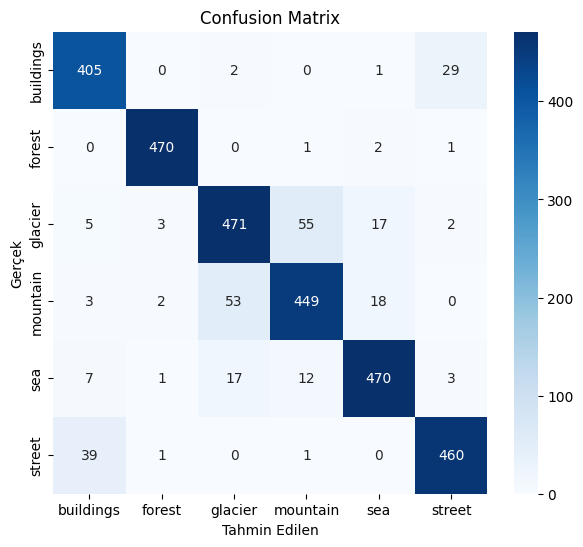

In [23]:
# test tahmini
test_gen.reset()
probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(probs, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=class_names, digits=2))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Tahmin Edilen"); plt.ylabel("Gerçek"); plt.title("Confusion Matrix")
plt.show()

Test sonuçlarım gayet başarılı çıktı. Genel doğruluk oranı %91 oldu ve tüm sınıflarda precision, recall ve f1-score değerleri oldukça yüksek. En iyi performansı “forest” sınıfında aldım (%99 precision ve recall), en zorlandığı kısım ise “mountain” sınıfı oldu, burada bazı örnekler “glacier” ile karışmış.

Confusion matrix’e baktığımda sınıflar arasında ciddi bir dengesizlik ya da büyük hata yok, genelde doğru sınıflandırmalar yapılmış. Özellikle “street” ve “sea” sınıflarında model oldukça sağlam tahminlerde bulunmuş.

Genel olarak hem metrikler hem de confusion matrix incelendiğinde modelin genelleme gücü çok iyi. Sadece benzer görsellere sahip sınıflarda ufak karışmalar var, onları da daha fazla veri veya fine-tuning ile iyileştirmek mümkün.

In [26]:
for layer in model.layers:
    print(layer.name)


input_layer_7
vgg16
flatten_3
dense_6
dropout_3
dense_7


In [46]:
for l in base_model.layers:
    print(l.name)


input_layer_6
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


İlk kısımda kendi kurduğum modelin katman isimlerini yazdırdım. Burada Input → VGG16 (base model) → Flatten → Dense(512) → Dropout → Dense(6) şeklinde katmanların sıralı yapısını net olarak görebiliyorum.

İkinci kısımda ise VGG16’nın kendi iç yapısını inceledim. Block1’den Block5’e kadar convolution ve pooling katmanlarını detaylı şekilde görebildim. Bu sayede hangi blokları dondurduğumu, hangi blokları fine-tuning için açabileceğimi daha iyi kontrol etme şansım oldu.

Yani bu çıktılar aslında model mimarisini daha yakından anlamamı sağladı ve fine-tuning için hangi katmanlarda oynama yapabileceğimi netleştirdi.

In [47]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

def show_eigencam(generator, idx=0, target_layer_name="block5_conv3", input_size=(128,128)):
    """
    generator : Keras DirectoryIterator (test_gen)
    idx       : generator içinden görsel indexi
    target_layer_name : VGG16 içindeki conv layer (default: block5_conv3)
    input_size: modele verdiğim hedef boyut (128x128 kullanıyorum)
    """
    # Görseli hazırla
    img_path = generator.filepaths[idx]
    img_bgr  = cv2.imread(img_path)
    if img_bgr is None:
        raise RuntimeError(f"Resim okunamadı: {img_path}")
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, input_size)
    x = np.expand_dims(img_resized/255.0, axis=0)  

    # Alt modeli yakala (parent modelin içinde gömülü)
    try:
        vgg_block = model.get_layer("vgg16")  # parent içindeki VGG16 alt modeli
    except ValueError:
        vgg_block = base_model

    # Feature extractor: alt modelin kendi grafiği
    # Parent grafiğe bağlanmıyoruz → KeyError riski yok.
    feature_extractor = tf.keras.models.Model(
        inputs=vgg_block.input,
        outputs=vgg_block.get_layer(target_layer_name).output
    )

    # 3) Feature map çıkar
    feature_maps = feature_extractor(x, training=False).numpy()[0]  # [H, W, C]

    # 4) Eigen-CAM (PCA’nın 1. bileşeni)
    H, W, C = feature_maps.shape
    reshaped = feature_maps.reshape((-1, C))                         # [H*W, C]
    reshaped_centered = reshaped - reshaped.mean(axis=0, keepdims=True)
    # SVD ile ana yön
    _, _, vh = np.linalg.svd(reshaped_centered, full_matrices=False)
    principal = vh[0]                                               # [C,]
    cam = np.dot(reshaped, principal).reshape(H, W)                 # [H, W]

    # 5) Normalize et
    cam = np.maximum(cam, 0)
    cam = cam / (cam.max() + 1e-8)

    # 6) Orijinal boyuta ölçekle ve renklendir
    heatmap = cv2.resize(cam, (img.shape[1], img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    # Tahmini al 
    probs = model.predict(x, verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    class_names = list(generator.class_indices.keys())
    pred_name = class_names[pred_idx] if pred_idx < len(class_names) else str(pred_idx)
    pred_conf = float(probs[pred_idx])

    # Bindir ve çiz
    superimposed = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.axis("off"); plt.title("Orijinal")
    plt.subplot(1,3,2); plt.imshow(heatmap, cmap="jet"); plt.axis("off"); plt.title(f"Eigen-CAM ({target_layer_name})")
    plt.subplot(1,3,3); plt.imshow(superimposed); plt.axis("off"); 
    plt.title(f"Pred: {pred_name} ({pred_conf:.2%})")
    plt.show()

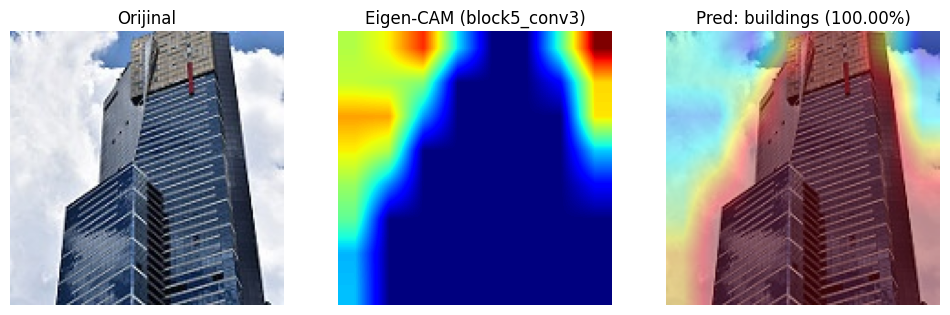

In [48]:
show_eigencam(test_gen, idx=0)

Eigen-CAM çıktısında modelin “buildings” sınıfını %100 güvenle doğru tahmin ettiğini görüyorum. Isı haritasına baktığımda modelin özellikle binanın gövde ve kenar hatlarına odaklandığını fark ettim. Yani gerçekten karar verirken doğru bölgeleri kullanıyor.

Bu görselleştirme benim için önemli çünkü modelin sadece rastgele öğrenmediğini, binaları tanımada gerçekten mantıklı özellikler üzerinden karar verdiğini kanıtlıyor. Modelin içini görmüş oldum diyebilirim.

# Hiperparametre Optimizasyonu 

## Hiperparametre Optimizasyonu (Keras Tuner)

Bu bölümde **Keras Tuner** kullanarak CNN modelim için hiperparametre optimizasyonu yaptım.  
Amaç, farklı kombinasyonları otomatik olarak deneyip en iyi sonuç veren parametreleri bulmak.  

### Optimizasyonu yapılan hiperparametreler:
- **CNN blok sayısı** (2–4 arası)
- **Filtre sayısı** (32, 64, 128)
- **Kernel boyutu** (3x3, 5x5)
- **Dense layer boyutu** (128, 256, 512)
- **Dropout oranı** (0.3 – 0.6 arası)
- **Learning rate** (1e-2, 1e-3, 1e-4)
- **Optimizer seçimi** (Adam, RMSProp, SGD)

### Kullanılan yöntem:
- **RandomSearch** ile `max_trials=10` olacak şekilde farklı kombinasyonlar denenmiştir.
- Amaç, **validation accuracy**’yi maksimize edecek en iyi hiperparametre setini bulmaktır.
- Bu yaklaşım sayesinde manuel deneme-yanılma süreci yerine otomatik ve sistematik bir optimizasyon yapılmıştır.


In [57]:
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers, regularizers


num_classes = 6
input_shape = (128,128,3)

def build_model(hp):
    model = keras.Sequential()

    # CNN blokları
    for i in range(hp.Int("conv_blocks", 2, 4, default=3)):
        model.add(layers.Conv2D(
            filters=hp.Choice(f"filters_{i}", [32, 64, 128]),
            kernel_size=hp.Choice(f"kernel_size_{i}", [3, 5]),
            activation="relu",
            padding="same",
            kernel_regularizer=regularizers.l2(1e-4),
            input_shape=input_shape if i == 0 else None
        ))
        model.add(layers.MaxPooling2D(pool_size=(2,2)))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(
        units=hp.Choice("dense_units", [128, 256, 512]),
        activation="relu",
        kernel_regularizer=regularizers.l2(1e-4)
    ))
    model.add(layers.Dropout(hp.Float("dropout", 0.3, 0.6, step=0.1, default=0.5)))

    # Çıkış katmanı
    model.add(layers.Dense(num_classes, activation="softmax"))

    # Optimizer & LR
    hp_learning_rate = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4])
    hp_optimizer = hp.Choice("optimizer", ["adam", "rmsprop", "sgd"])

    if hp_optimizer == "adam":
        optimizer = keras.optimizers.Adam(learning_rate=hp_learning_rate)
    elif hp_optimizer == "rmsprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=hp_learning_rate)
    else:
        optimizer = keras.optimizers.SGD(learning_rate=hp_learning_rate, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [58]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=10,  # kaç farklı kombinasyon denenecek
    executions_per_trial=1,
    directory="tuner_dir",
    project_name="cnn_hyperopt"
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
tuner.search(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)]
)


Trial 3 Complete [00h 09m 44s]
val_accuracy: 0.6162624955177307

Best val_accuracy So Far: 0.8174037337303162
Total elapsed time: 00h 29m 33s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
2                 |4                 |conv_blocks
32                |64                |filters_0
5                 |3                 |kernel_size_0
32                |128               |filters_1
5                 |5                 |kernel_size_1
64                |64                |filters_2
3                 |5                 |kernel_size_2
128               |512               |dense_units
0.3               |0.3               |dropout
0.01              |0.001             |learning_rate
adam              |adam              |optimizer
32                |32                |filters_3
3                 |3                 |kernel_size_3

Epoch 1/10
351/351 ━━━━━━━━━━━━━━━━━━━━ 64s 170ms/step - accuracy: 0.1747 - loss: 4.5170 - val_accuracy: 0.1698 - val_loss: 2.0030


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Seçilen Hiperparametreler:")
print(f"Conv Blocks: {best_hps.get('conv_blocks')}")
for i in range(best_hps.get('conv_blocks')):
    print(f"Filters {i}: {best_hps.get(f'filters_{i}')}")
    print(f"Kernel {i}: {best_hps.get(f'kernel_size_{i}')}")
print(f"Dense Units: {best_hps.get('dense_units')}")
print(f"Dropout: {best_hps.get('dropout')}")
print(f"Optimizer: {best_hps.get('optimizer')}, LR: {best_hps.get('learning_rate')}")


In [ ]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.legend()
plt.title("Model Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.legend()
plt.title("Model Loss")

plt.show()
